<a href="https://colab.research.google.com/github/GiorgiaVitanza/DataScience/blob/master/MLP_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 12. Exercise: Fashion MNIST Classification

**Your Task**: Adapt the CNN model we've built to classify the Fashion MNIST dataset.

The Fashion MNIST dataset consists of 28×28 grayscale images of 10 fashion categories:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

**Steps**:
1. Load the Fashion MNIST dataset instead of regular MNIST
2. Adapt the CNN model if necessary (you might want to use more filters or deeper architecture for this more complex dataset)
3. Train and evaluate the model
4. Visualize the results and compare with the digit classification results

**Hint**: You can load Fashion MNIST using `torchvision.datasets.FashionMNIST` instead of `datasets.MNIST`.

In [3]:
# Install required packages (uncomment if needed)
! pip install torch torchvision lightning matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [5]:
# Exercise starter code: Loading Fashion MNIST dataset
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Fashion MNIST mean and std
])

# Define the Fashion MNIST class names for better visualization
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [15]:
fashion_mnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=fashion_transform)


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.82MB/s]


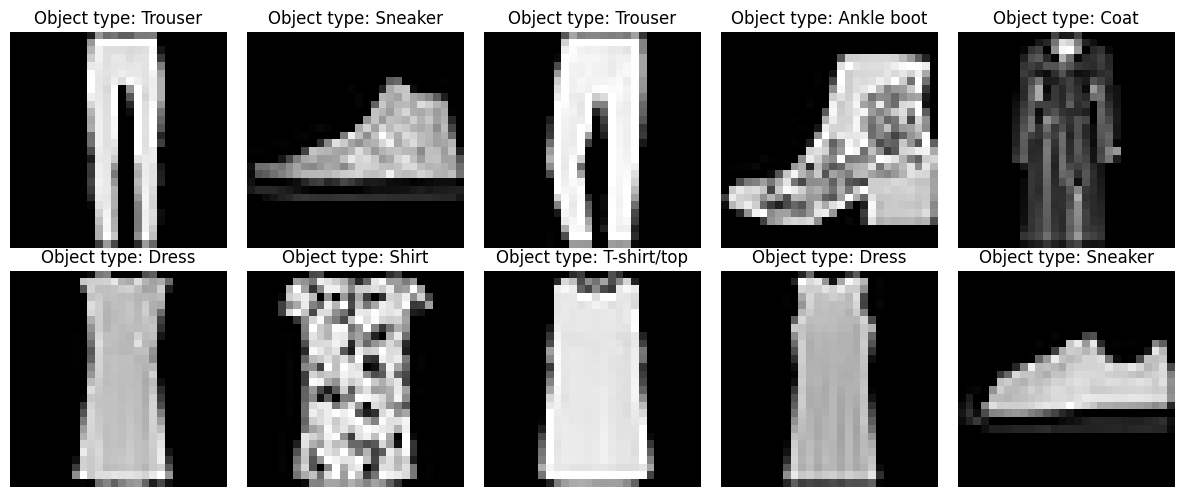

In [21]:
# Display 10 random images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    idx = np.random.randint(len(fashion_mnist_train))
    img, label = fashion_mnist_train[idx]
    img = img.squeeze().numpy()  # Remove channel dimension and convert to numpy

    ax.imshow(img, cmap='gray')
    ax.set_title(f'Object type: {fashion_class_names[label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [28]:
# TODO: Create a FashionMNISTDataModule similar to MNISTDataModule

class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = fashion_transform

    def prepare_data(self):
        # Download data if needed (only once)
        datasets.FashionMNIST('./data', train=True, download=True, transform=fashion_transform)

    def setup(self, stage=None):
        # Assign train/val/test datasets
        if stage == "fit" or stage is None:
            mnist_full = datasets.FashionMNIST(
                self.data_dir, train=True, transform=self.transform
            )
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = datasets.FashionMNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=4)

In [29]:
# TODO: Implement FashionMNISTClassifierCNN based on MNISTClassifierCNN
class FashionMNISTClassifierCNN(pl.LightningModule):
    def __init__(self, hidden_size=32, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # Convolutional layers

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of features after convolutions and pooling
        # After 2 pooling layers with stride 2, spatial dimensions are reduced by factor of 4
        # So 28x28 becomes 7x7, and we have 32 feature maps
        self.fc_input_size = 32 * 7 * 7

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)  # 10 output classes (digits 0-9)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]

        # First convolutional block
        x = F.relu(self.conv1(x))  # Shape: [batch_size, 32, 28, 28]
        x = self.pool(x)  # Shape: [batch_size, 32, 14, 14]

        # Second convolutional block
        x = F.relu(self.conv2(x))  # Shape: [batch_size, 64, 14, 14]
        x = self.pool(x)  # Shape: [batch_size, 64, 7, 7]

        # Flatten for fully connected layers
        x = x.view(-1, self.fc_input_size)  # Shape: [batch_size, 64*7*7]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Shape: [batch_size, 10]

        return x

    # Reusing the same training, validation, and test steps as the MLP model
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

        return {"test_loss": loss, "test_acc": acc, "preds": preds, "targets": y}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


In [30]:
# TODO: Train and evaluate your model on Fashion MNIST

# Setup the data module
data_module = FashionMNISTDataModule(batch_size=128)

# Define a function to train and evaluate a model
def train_and_evaluate(model, model_name, max_epochs=5):
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=True,
        mode='min'
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[early_stopping],
        accelerator='auto',  # Use GPU if available
        logger=True,
    )

    # Train the model
    print(f"\nTraining {model_name}...")
    trainer.fit(model, data_module)

    # Test the model
    print(f"\nTesting {model_name}...")
    test_results = trainer.test(model, data_module)

    return model, test_results

In [31]:
# Train and evaluate the CNN model
cnn_model = FashionMNISTClassifierCNN(hidden_size=32, learning_rate=0.001)
cnn_model, cnn_results = train_and_evaluate(cnn_model, "CNN Model", max_epochs=10)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Training CNN Model...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 160    | train
1 | conv2   | Conv2d    | 4.6 K  | train
2 | pool    | MaxPool2d | 0      | train
3 | fc1     | Linear    | 50.2 K | train
4 | fc2     | Linear    | 330    | train
5 | dropout | Dropout   | 0      | train
----------------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.422


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.357


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.334


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.304


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.293


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.282


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.280


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.264


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Testing CNN Model...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9003999829292297     │
│         test_loss         │    0.2799398601055145     │
└───────────────────────────┴───────────────────────────┘

CNN Model Predictions:


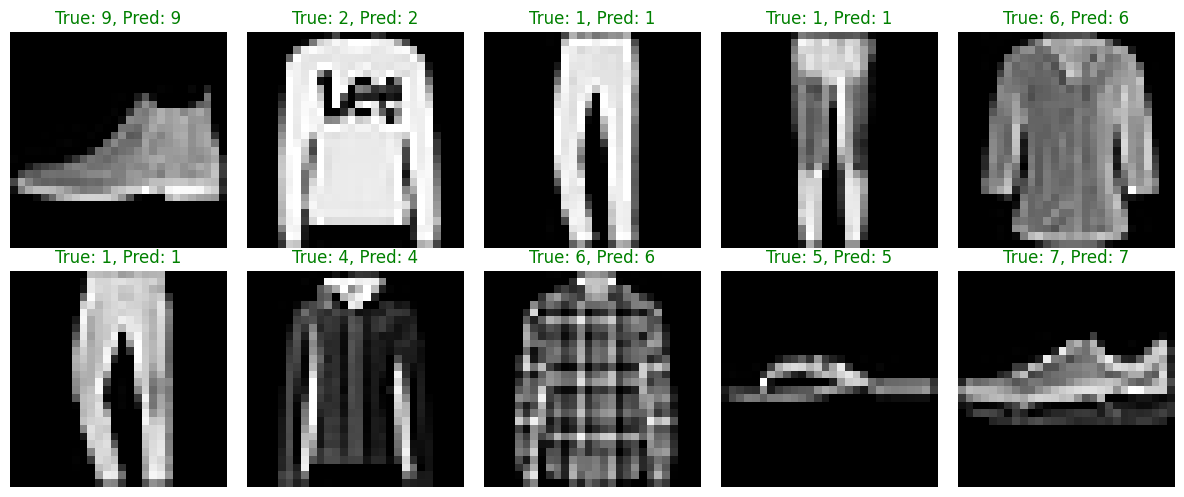

In [32]:
# TODO: Visualize some predictions and analyze the results
def show_predictions(model, num_samples=10):
    # Get a batch of test data
    test_loader = data_module.test_dataloader()
    batch = next(iter(test_loader))
    images, labels = batch

    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = images[i].squeeze().cpu().numpy()
        label = labels[i].item()
        pred = preds[i].item()

        ax.imshow(img, cmap='gray')
        title_color = 'green' if pred == label else 'red'
        ax.set_title(f'True: {label}, Pred: {pred}', color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions from CNN model
print("CNN Model Predictions:")
show_predictions(cnn_model)

In [33]:
from torchsummary import summary

# Print summary of CNN model
print("\nCNN Model Summary:")
summary(cnn_model, input_size=(1, 28, 28))


CNN Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                   [-1, 32]          50,208
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 10]             330
Total params: 55,338
Trainable params: 55,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.21
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


We can conclude that the CNN gives us a good classification because the accuracy is  0.90 and also the visualization and the comparison between expected images and true ones are in agreement.